In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from models import get_model

/ibex/scratch/gasanoe/unlearning/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import data

# Scalar Product Classifier Performance

## Defining the new classifier

In [4]:
class ScalarProductClassifier(nn.Module):
    def __init__(self):
        super(ScalarProductClassifier, self).__init__()
    
    def forward(self, input1, input2):
        output = torch.sum(input1 * input2, dim=1)
        # output = torch.sigmoid(output)
        return output

## Loading the model

In [5]:
weight_path = '/home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/logs/model_resnet18_sam_True_rho_0.5_lr_0.1_07-03-09:33:15_model.pth'
model = get_model('resnet18', num_classes=100, pretrained_weights=None, weight_path=weight_path)

Loaded weights from /home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/logs/model_resnet18_sam_True_rho_0.5_lr_0.1_07-03-09:33:15_model.pth
Model 'resnet18' loaded successfully!
Number of layers: 62
Total parameters: 11227812
Trainable parameters: 11227812


## Generating the loaders

In [6]:
dataset_handler = data.CIFAR100Handler(batch_size=128,
                                       validation_split=0.1,
                                       random_seed=42,
                                       data_dir='/home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/data/cifar100')
train_loader, val_loader, test_loader = dataset_handler.get_dataloaders()

Files already downloaded and verified
Files already downloaded and verified


## Distribution of representations

### Distribution independent from classes (unsupervised fashion)

In [7]:
device = torch.device('cuda')
model = model.to(device)

In [8]:
all_scores_same_sets = torch.empty(0, 1, dtype=torch.float).to(device)
all_scores_different_sets = torch.empty(0, 1, dtype=torch.float).to(device)
classifier = ScalarProductClassifier().to(device)

In [8]:
def get_all_same_set_scores(loader, model, device, classifier):
    model.eval()
    all_scores = torch.empty(0, 1).to(device)
    with torch.no_grad():
        for batch in loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)

            shuffled_indices = torch.randperm(outputs.size(0))
            shuffled_outputs = outputs[shuffled_indices]

            same_set_scores = classifier(outputs, shuffled_outputs).unsqueeze(1)
            all_scores = torch.cat([all_scores, same_set_scores], dim=0)
    return all_scores

In [10]:
train_same_set_scores = get_all_same_set_scores(train_loader, model, device, classifier)
val_same_set_scores = get_all_same_set_scores(val_loader, model, device, classifier)

In [11]:
all_scores_same_sets = torch.cat((train_same_set_scores, val_same_set_scores), dim=0)

In [9]:
import gc

In [10]:
def get_all_different_set_scores(loader_1, loader_2, model, device, classifier, n_epochs=3):
    model.eval()
    all_scores = torch.empty(0, 1,  dtype=torch.float).to(device)
    with torch.no_grad():
        for epoch in range(n_epochs):
            print(f'Epoch {epoch}')
            for batch_num, (batch_1, batch_2) in enumerate(zip(loader_1, loader_2)):
                print(f'Batch num {batch_num}')
                inputs_1, labels_1 = batch_1
                inputs_2, labels_2 = batch_2

                # Ensure sizes match
                if inputs_1.size(0) != inputs_2.size(0):
                    min_batch_size = min(inputs_1.size(0), inputs_2.size(0))
                    inputs_1, labels_1 = inputs_1[:min_batch_size], labels_1[:min_batch_size]
                    inputs_2, labels_2 = inputs_2[:min_batch_size], labels_2[:min_batch_size]

                inputs_1, labels_1 = inputs_1.to(device), labels_1.to(device)
                inputs_2, labels_2 = inputs_2.to(device), labels_2.to(device)

                
                outputs_1 = model(inputs_1)
                outputs_2 = model(inputs_2)

                shuffled_indices = torch.randperm(outputs_2.size(0))
                outputs_2 = outputs_2[shuffled_indices]

                different_sets_scores = classifier(outputs_1, outputs_2).unsqueeze(1)
                all_scores = torch.cat([all_scores, different_sets_scores], dim=0)

                del inputs_1, labels_1, inputs_2, labels_2, outputs_1, outputs_2, different_sets_scores
                torch.cuda.empty_cache()
                gc.collect()
    return all_scores

In [14]:
all_scores_different_sets = get_all_different_set_scores(train_loader, val_loader, model, device, classifier, 5)

Epoch 0
Batch num 0
Batch num 1
Batch num 2
Batch num 3
Batch num 4
Batch num 5
Batch num 6
Batch num 7
Batch num 8
Batch num 9
Batch num 10
Batch num 11
Batch num 12
Batch num 13
Batch num 14
Batch num 15
Batch num 16
Batch num 17
Batch num 18
Batch num 19
Batch num 20
Batch num 21
Batch num 22
Batch num 23
Batch num 24
Batch num 25
Batch num 26
Batch num 27
Batch num 28
Batch num 29
Batch num 30
Batch num 31
Batch num 32
Batch num 33
Batch num 34
Batch num 35
Batch num 36
Batch num 37
Batch num 38
Batch num 39
Epoch 1
Batch num 0
Batch num 1
Batch num 2
Batch num 3
Batch num 4
Batch num 5
Batch num 6
Batch num 7
Batch num 8
Batch num 9
Batch num 10
Batch num 11
Batch num 12
Batch num 13
Batch num 14
Batch num 15
Batch num 16
Batch num 17
Batch num 18
Batch num 19
Batch num 20
Batch num 21
Batch num 22
Batch num 23
Batch num 24
Batch num 25
Batch num 26
Batch num 27
Batch num 28
Batch num 29
Batch num 30
Batch num 31
Batch num 32
Batch num 33
Batch num 34
Batch num 35
Batch num 36
Bat

### Plotting scores

In [15]:
from matplotlib import pyplot as plt

In [16]:
import numpy as np

In [17]:
all_scores_same_sets = all_scores_same_sets.cpu().numpy().squeeze(1)
all_scores_different_sets = all_scores_different_sets.cpu().numpy().squeeze(1)

In [18]:
len(all_scores_same_sets)

50000

In [19]:
all_scores_same_sets = np.sort(all_scores_same_sets)
all_scores_different_sets = np.sort(all_scores_different_sets)

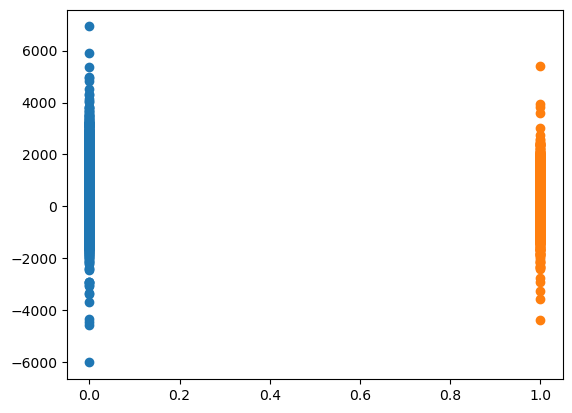

In [20]:
plt.scatter(x = np.zeros(all_scores_same_sets.size), y = all_scores_same_sets)
plt.scatter(x = np.ones(all_scores_different_sets.size), y = all_scores_different_sets)

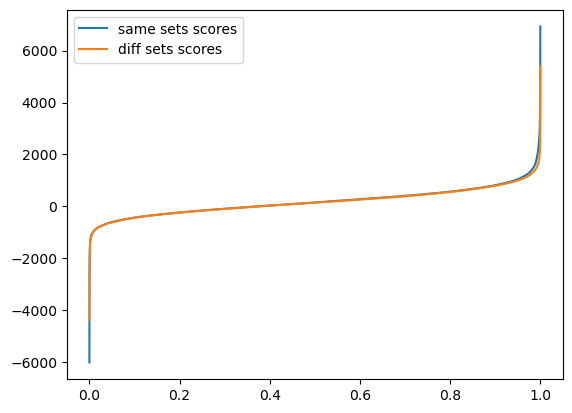

In [21]:
plt.plot(np.linspace(start=0, stop=1., num=len(all_scores_same_sets)), all_scores_same_sets, label='same sets scores')
plt.plot(np.linspace(start=0, stop=1., num=len(all_scores_different_sets)), all_scores_different_sets, label='diff sets scores')
plt.legend()

In [22]:
all_scores_same_sets_middle = np.array([x for x in all_scores_same_sets if -100. <= x <= 100.])

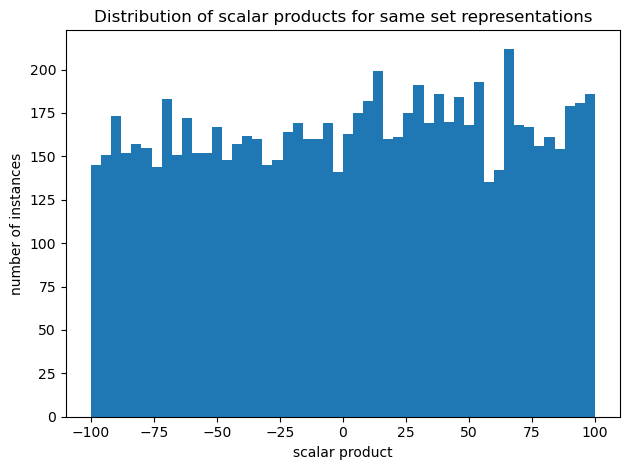

In [23]:
plt.hist(all_scores_same_sets_middle, bins=50)
plt.title('Distribution of scalar products for same set representations')
plt.xlabel('scalar product')
plt.ylabel('number of instances')
plt.tight_layout()

In [24]:
all_scores_different_sets_middle = np.array([x for x in all_scores_different_sets if -100. <= x <= 100.])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


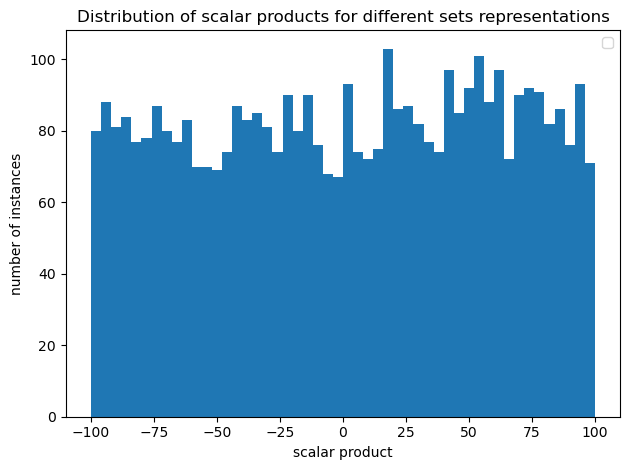

In [25]:
plt.hist(all_scores_different_sets_middle, bins=50)
plt.title('Distribution of scalar products for different sets representations')
plt.xlabel('scalar product')
plt.ylabel('number of instances')
plt.tight_layout()
plt.legend()

# Supervised contrast

In [11]:
import copy

In [12]:
from data import CorrespondingLoaders

In [13]:
train_train_1_loader, train_train_2_loader = CorrespondingLoaders(train_loader, train_loader, seed=5).get_loaders()

Dataset CIFAR100
    Number of datapoints: 50000
    Root location: /home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/data/cifar100
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.5071, 0.4867, 0.4408), std=(0.2675, 0.2565, 0.2761))
           )
Dataset CIFAR100
    Number of datapoints: 50000
    Root location: /home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/data/cifar100
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.5071, 0.4867, 0.4408), std=(0.2675, 0.2565, 0.2761))
           )


In [14]:
val_val_1_loader, val_val_2_loader = CorrespondingLoaders(val_loader, val_loader, seed=20).get_loaders()

Dataset CIFAR100
    Number of datapoints: 50000
    Root location: /home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/data/cifar100
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.5071, 0.4867, 0.4408), std=(0.2675, 0.2565, 0.2761))
           )
Dataset CIFAR100
    Number of datapoints: 50000
    Root location: /home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/data/cifar100
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.5071, 0.4867, 0.4408), std=(0.2675, 0.2565, 0.2761))
           )


In [15]:
train_val_1_loader, train_val_2_loader = CorrespondingLoaders(train_loader, val_loader, seed=15).get_loaders()

Dataset CIFAR100
    Number of datapoints: 50000
    Root location: /home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/data/cifar100
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.5071, 0.4867, 0.4408), std=(0.2675, 0.2565, 0.2761))
           )
Dataset CIFAR100
    Number of datapoints: 50000
    Root location: /home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/data/cifar100
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.5071, 0.4867, 0.4408), std=(0.2675, 0.2565, 0.2761))
           )


In [16]:
def get_all_same_set_scores_synchronized(loader_1, loader_2, model, device, classifier):
    model.eval()
    all_scores = torch.empty(0, 1).to(device)
    with torch.no_grad():
        for batch_1, batch_2 in zip(loader_1, loader_2):
            inputs_1, labels_1 = batch_1
            inputs_2, labels_2 = batch_2
            assert labels_1.eq(labels_2).all()
            assert inputs_1.ne(inputs_2).any()
            inputs_1, labels_1 = inputs_1.to(device), labels_1.to(device)
            inputs_2, labels_2 = inputs_2.to(device), labels_2.to(device)
            
            outputs_1 = model(inputs_1)
            outputs_2 = model(inputs_2)

            same_set_scores = classifier(outputs_1, outputs_2).unsqueeze(1)
            all_scores = torch.cat([all_scores, same_set_scores], dim=0)
    return all_scores

In [32]:
train_same_set_scores_sync = get_all_same_set_scores_synchronized(train_train_1_loader, train_train_2_loader, model, device, classifier)

In [33]:
val_same_set_scores_sync = get_all_same_set_scores_synchronized(val_val_1_loader, val_val_2_loader, model, device, classifier)

In [34]:
all_scores_same_sets_synchronized = torch.cat((train_same_set_scores_sync, val_same_set_scores_sync), dim=0)

In [35]:
all_scores_different_sets_synchronized = get_all_different_set_scores(train_val_1_loader, train_val_2_loader, model, device, classifier, n_epochs=1)

Epoch 0
Batch num 0
Batch num 1
Batch num 2
Batch num 3
Batch num 4
Batch num 5
Batch num 6
Batch num 7
Batch num 8
Batch num 9
Batch num 10
Batch num 11
Batch num 12
Batch num 13
Batch num 14
Batch num 15
Batch num 16
Batch num 17
Batch num 18
Batch num 19
Batch num 20
Batch num 21
Batch num 22
Batch num 23
Batch num 24
Batch num 25
Batch num 26
Batch num 27
Batch num 28
Batch num 29
Batch num 30
Batch num 31
Batch num 32
Batch num 33
Batch num 34
Batch num 35
Batch num 36
Batch num 37
Batch num 38
Batch num 39
Batch num 40
Batch num 41
Batch num 42
Batch num 43
Batch num 44
Batch num 45
Batch num 46
Batch num 47
Batch num 48
Batch num 49
Batch num 50
Batch num 51
Batch num 52
Batch num 53
Batch num 54
Batch num 55
Batch num 56
Batch num 57
Batch num 58
Batch num 59
Batch num 60
Batch num 61
Batch num 62
Batch num 63
Batch num 64
Batch num 65
Batch num 66
Batch num 67
Batch num 68
Batch num 69
Batch num 70
Batch num 71
Batch num 72
Batch num 73
Batch num 74
Batch num 75
Batch num 76
B

In [36]:
all_scores_same_sets_synchronized = all_scores_same_sets_synchronized.cpu().numpy()
all_scores_different_sets_synchronized = all_scores_different_sets_synchronized.cpu().numpy()

In [37]:
all_scores_same_sets_synchronized = all_scores_same_sets_synchronized.squeeze(1)
all_scores_different_sets_synchronized = all_scores_different_sets_synchronized.squeeze(1)

In [38]:
all_scores_same_sets_synchronized[:10]

array([1100.0244 ,  423.10345, 1048.3677 ,  290.68805,  889.5818 ,
       1033.3887 ,  536.8711 , 1195.8757 ,  851.4346 , 1059.248  ],
      dtype=float32)

In [51]:
all_scores_same_sets_synchronized_middle = np.array([x for x in all_scores_same_sets_synchronized if -1000. < x < 3000.])
all_scores_different_sets_synchronized_middle = np.array([x for x in all_scores_different_sets_synchronized if -2000. < x < 2000.])

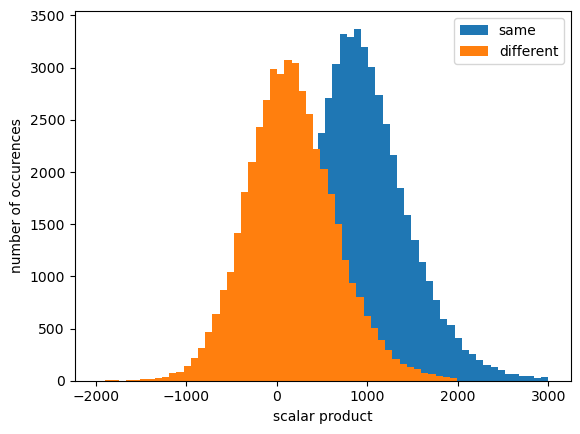

In [54]:
plt.hist(all_scores_same_sets_synchronized_middle, bins=50, label='same')
plt.hist(all_scores_different_sets_synchronized_middle, bins=50, label='different')
plt.xlabel('scalar product')
plt.ylabel('number of occurences')
plt.legend()

# Supervised + small NN

In [20]:
class ContrastiveClassifier(nn.Module):
    def __init__(self, output_size):
        super(ContrastiveClassifier, self).__init__()
        self.fc1 = nn.Linear(2 * output_size + 1, 10)  # Assuming output size of model1 and model2 is 256 each
        self.sigmoid1 = nn.Sigmoid()
        self.fc2 = nn.Linear(10, 1)
        self.sigmoid2 = nn.Sigmoid()
    
    def forward(self, x1, x2):
        dot_product = torch.sum(x1 * x2, dim=1, keepdim=True)
        x = torch.cat((x1, x2, dot_product), dim=1)
        x = self.fc1(x)
        x = self.sigmoid1(x)
        x = self.fc2(x)
        x = self.sigmoid2(x)
        return x

In [21]:
from torch import optim

In [22]:
classifier = ContrastiveClassifier(100).to(device)
criterion = nn.BCELoss()
optimizer = optim.SGD(classifier.parameters(), lr=0.01, momentum=0.9)

In [23]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [24]:
for epoch in range(20):
    print(f'epoch {epoch}')
    
    # Training and validation within the same epoch
    for batch_num, (batch_train_1, batch_train_2, batch_val_1, batch_val_2, batch_diff_1, batch_diff_2) in enumerate(zip(train_train_1_loader, train_train_2_loader, val_val_1_loader, val_val_1_loader, train_val_1_loader, train_val_2_loader)):
        
        # Same sets - train
        inputs_1, labels_1 = batch_train_1
        inputs_2, labels_2 = batch_train_2
        assert labels_1.eq(labels_2).all()
        assert inputs_1.ne(inputs_2).any()
        inputs_1, labels_1 = inputs_1.to(device), labels_1.to(device)
        inputs_2, labels_2 = inputs_2.to(device), labels_2.to(device)
            
        outputs_1 = model(inputs_1)
        outputs_2 = model(inputs_2)

        same_set_scores = classifier(outputs_1, outputs_2).squeeze(1)
        loss = criterion(same_set_scores, torch.ones(outputs_1.size(0)).to(device))
        loss.backward()
        optimizer.step()
        print(f'Training Loss (same set): {loss.item()}')
        del inputs_1, labels_1, inputs_2, labels_2, outputs_1, outputs_2, same_set_scores
        gc.collect()
        
        # Same sets - validation
        inputs_1, labels_1 = batch_val_1
        inputs_2, labels_2 = batch_val_2
        assert labels_1.eq(labels_2).all()
        assert inputs_1.ne(inputs_2).any()
        inputs_1, labels_1 = inputs_1.to(device), labels_1.to(device)
        inputs_2, labels_2 = inputs_2.to(device), labels_2.to(device)
            
        outputs_1 = model(inputs_1)
        outputs_2 = model(inputs_2)

        same_set_scores = classifier(outputs_1, outputs_2).squeeze(1)
        val_loss = criterion(same_set_scores, torch.ones(outputs_1.size(0)).to(device))
        print(f'Validation Loss (same set): {val_loss.item()}')
        del inputs_1, labels_1, inputs_2, labels_2, outputs_1, outputs_2, same_set_scores
        gc.collect()
        
        # Different sets
        print(f'Batch num {batch_num}')
        inputs_1, labels_1 = batch_diff_1
        inputs_2, labels_2 = batch_diff_2

        # Ensure sizes match
        if inputs_1.size(0) != inputs_2.size(0):
            min_batch_size = min(inputs_1.size(0), inputs_2.size(0))
            inputs_1, labels_1 = inputs_1[:min_batch_size], labels_1[:min_batch_size]
            inputs_2, labels_2 = inputs_2[:min_batch_size], labels_2[:min_batch_size]

        inputs_1, labels_1 = inputs_1.to(device), labels_1.to(device)
        inputs_2, labels_2 = inputs_2.to(device), labels_2.to(device)

        outputs_1 = model(inputs_1)
        outputs_2 = model(inputs_2)

        shuffled_indices = torch.randperm(outputs_2.size(0))
        outputs_2 = outputs_2[shuffled_indices]

        different_sets_scores = classifier(outputs_1, outputs_2).squeeze(1)
        diff_loss = criterion(different_sets_scores, torch.zeros(outputs_1.size(0)).to(device))
        diff_loss.backward()
        optimizer.step()
        print(f'Training Loss (different set): {diff_loss.item()}')
        del inputs_1, labels_1, inputs_2, labels_2, outputs_1, outputs_2, different_sets_scores
        torch.cuda.empty_cache()
        gc.collect()


epoch 0
Training Loss (same set): 0.6438549757003784


AssertionError: 

In [68]:
# for epoch in range(20):
#     print(f'epoch {epoch}')
#     # same sets
#     # train
#     for batch_1, batch_2 in zip(train_train_1_loader, train_train_2_loader):
#         inputs_1, labels_1 = batch_1
#         inputs_2, labels_2 = batch_2
#         assert labels_1.eq(labels_2).all()
#         assert inputs_1.ne(inputs_2).any()
#         inputs_1, labels_1 = inputs_1.to(device), labels_1.to(device)
#         inputs_2, labels_2 = inputs_2.to(device), labels_2.to(device)
            
#         outputs_1 = model(inputs_1)
#         outputs_2 = model(inputs_2)

#         same_set_scores = classifier(outputs_1, outputs_2).squeeze(1)
#         loss = criterion(same_set_scores, torch.ones(outputs_1.size(0)).to(device))
#         loss.backward()
#         optimizer.step()
#         print(loss)
#         del inputs_1, labels_1, inputs_2, labels_2, outputs_1, outputs_2, same_set_scores
#         gc.collect()
#     # validation
#     for batch_1, batch_2 in zip(val_val_1_loader, val_val_1_loader):
#         inputs_1, labels_1 = batch_1
#         inputs_2, labels_2 = batch_2
#         assert labels_1.eq(labels_2).all()
#         assert inputs_1.ne(inputs_2).any()
#         inputs_1, labels_1 = inputs_1.to(device), labels_1.to(device)
#         inputs_2, labels_2 = inputs_2.to(device), labels_2.to(device)
            
#         outputs_1 = model(inputs_1)
#         outputs_2 = model(inputs_2)

#         same_set_scores = classifier(outputs_1, outputs_2).squeeze(1)
#         loss = criterion(same_set_scores, torch.ones(outputs_1.size(0)).to(device))
#         loss.backward()
#         optimizer.step()
#         print(loss)
#         del inputs_1, labels_1, inputs_2, labels_2, outputs_1, outputs_2, same_set_scores
#         gc.collect()
#     # different sets
    
#     for batch_num, (batch_1, batch_2) in enumerate(zip(train_val_1_loader, train_val_2_loader)):
#         print(f'Batch num {batch_num}')
#         inputs_1, labels_1 = batch_1
#         inputs_2, labels_2 = batch_2

#         # Ensure sizes match
#         if inputs_1.size(0) != inputs_2.size(0):
#             min_batch_size = min(inputs_1.size(0), inputs_2.size(0))
#             inputs_1, labels_1 = inputs_1[:min_batch_size], labels_1[:min_batch_size]
#             inputs_2, labels_2 = inputs_2[:min_batch_size], labels_2[:min_batch_size]

#         inputs_1, labels_1 = inputs_1.to(device), labels_1.to(device)
#         inputs_2, labels_2 = inputs_2.to(device), labels_2.to(device)

                
#         outputs_1 = model(inputs_1)
#         outputs_2 = model(inputs_2)

#         shuffled_indices = torch.randperm(outputs_2.size(0))
#         outputs_2 = outputs_2[shuffled_indices]

#         different_sets_scores = classifier(outputs_1, outputs_2).squeeze(1)
#         loss = criterion(same_set_scores, torch.zeros(outputs_1.size(0)).to(device))
#         loss.backward()
#         optimizer.step()
#         print(loss)
#         del inputs_1, labels_1, inputs_2, labels_2, outputs_1, outputs_2, different_sets_scores
#         torch.cuda.empty_cache()
#         gc.collect()

epoch 0
tensor(0.6324, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5545, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4798, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4238, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3432, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2537, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1639, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1029, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0545, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0236, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0147, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0075, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0065, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>